In [2]:
# This simulates optimisation for a BTM Bess for a site with: 
# load (and load forecast)
# production (solar) and production forecasst
# one or more battery units
# Single DA-style market. No explicit ancillary/mFRR participation is included (yet).
# Time horizon: 24 hours, 1-hour resolution (24 timesteps).
# Objective: Minimise cost of energy imports – revenue from exports + monetised degradation.

# It shows concretely: 
# 1. How the optimiser “decides” when to charge/discharge.
# 2. Computational tractability (runtime on laptop vs cloud scale).
# 3. The impact of degradation cost (e.g. if you price degradation at 2¢/kWh cycled, dispatch shifts).

# It can be extended incrementally to match a production architecture.




# Assets:
# 2 or 3 batteries, each with different capacity/power limits, efficiencies, and degradation costs.

# Inputs (simple synthetic data):
# Hourly load profile (e.g. industrial process baseline).
# Hourly PV generation profile.
# Hourly day-ahead prices (could be sinusoidal or pulled from a dataset).

# Constraints:
# SOC dynamics and limits per battery.
# Per-battery charge/discharge power caps.
# Site-level balance (load = PV + batteries + grid).
# Grid import/export allowed (positive = import, negative = export).
# minimum SOC buffer for ancillary services/imbalance

# Outputs 
# Optimal grid import/export profile.
# Per-battery charge/discharge schedule.
# Per-battery SOC trajectories.
# Site-level cost vs. “do nothing” baseline.

# Stretch features - NOT included:

# Binary constraint for non-simultaneous charge/discharge (turns LP optimisation into MILP).
# Cumulative throughput cap to mimic warranty.
# Rolling horizon (reoptimise with updated forecasts).

#     # This emulator was created after the model described here: https://chatgpt.com/share/68bee733-cb1c-8001-85dd-55ecb6bef662

In [3]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

np.random.seed(1)
T = 24  # hours
dt = 1.0
timesteps = np.arange(T)


In [4]:
# Load, PV, price profiles
base_load = 80 + 10*np.sin(2*np.pi*(timesteps-6)/24)
pv = np.maximum(0, 40 * np.sin(np.pi*(timesteps-6)/12))
price = 0.08 + 0.06*np.sin(2*np.pi*(timesteps-16)/24)

# Battery definitions
batteries = [
    {
        "id": "BAT_A",
        "capacity_kWh": 200.0,
        "p_charge_kW": 100.0,
        "p_discharge_kW": 100.0,
        "eta_c": 0.97,
        "eta_d": 0.97,
        "soc_init": 0.5,
        "soc_min": 0.05,
        "soc_max": 0.95,
        "degradation_cost_per_kWh": 0.001,
        "reserve_kWh": 20.0
    },
    {
        "id": "BAT_B",
        "capacity_kWh": 100.0,
        "p_charge_kW": 50.0,
        "p_discharge_kW": 50.0,
        "eta_c": 0.98,
        "eta_d": 0.98,
        "soc_init": 0.6,
        "soc_min": 0.05,
        "soc_max": 0.95,
        "degradation_cost_per_kWh": 0.015,
        "reserve_kWh": 10.0
    }
]

nB = len(batteries)

In [5]:
# Decision variables
ch = [cp.Variable(T, nonneg=True) for _ in range(nB)]
dis = [cp.Variable(T, nonneg=True) for _ in range(nB)]
soc = [cp.Variable(T+1) for _ in range(nB)]
throughput = [cp.Variable(T, nonneg=True) for _ in range(nB)]
G = cp.Variable(T)

constraints = []

# Build constraints per battery
for i, b in enumerate(batteries):
    E = b["capacity_kWh"]
    reserve = b["reserve_kWh"]
    # Effective SOC min/max keep symmetric reserve out of scheduling
    soc_min_eff = b["soc_min"] * E + reserve/2.0
    soc_max_eff = b["soc_max"] * E - reserve/2.0
    soc_init_kWh = b["soc_init"] * E
    constraints += [soc[i][0] == soc_init_kWh]
    for t in range(T):
        constraints += [
            soc[i][t+1] == soc[i][t] + b["eta_c"] * ch[i][t] * dt - (1.0 / b["eta_d"]) * dis[i][t] * dt
        ]
        constraints += [ch[i][t] <= b["p_charge_kW"], dis[i][t] <= b["p_discharge_kW"]]
        constraints += [throughput[i][t] >= ch[i][t] + dis[i][t]]
        constraints += [soc[i][t+1] >= soc_min_eff, soc[i][t+1] <= soc_max_eff]
# Build site-level power balance
for t in range(T):
    # Power balance: load = PV + sum(dis) - sum(ch) + G
    total_dis = sum(dis[i][t] for i in range(nB))
    total_ch = sum(ch[i][t] for i in range(nB))
    constraints += [base_load[t] == pv[t] + total_dis - total_ch + G[t]]



In [6]:
energy_cost = cp.sum(cp.multiply(price, G))
deg_cost = sum(b["degradation_cost_per_kWh"] * cp.sum(throughput[i]) for i,b in enumerate(batteries))
objective = cp.Minimize(energy_cost + deg_cost)


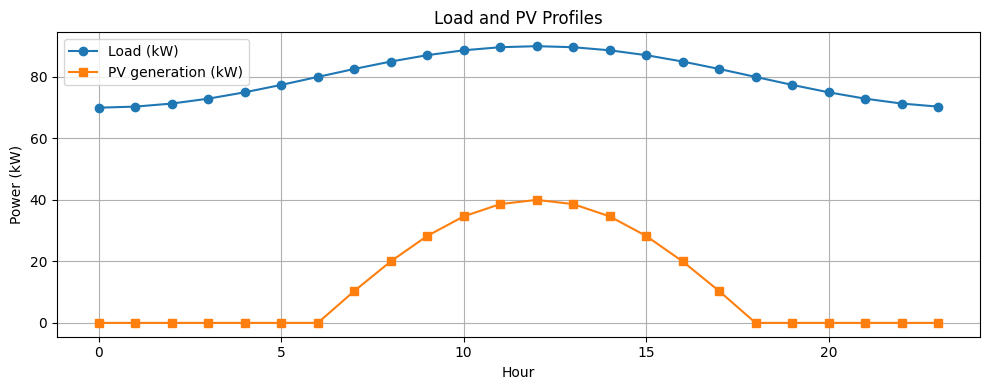

In [7]:
# Plot inputs: load and generation
plt.figure(figsize=(10,4))
plt.plot(timesteps, base_load, label="Load (kW)", marker='o')
plt.plot(timesteps, pv, label="PV generation (kW)", marker='s')
plt.xlabel("Hour")
plt.ylabel("Power (kW)")
plt.title("Load and PV Profiles")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


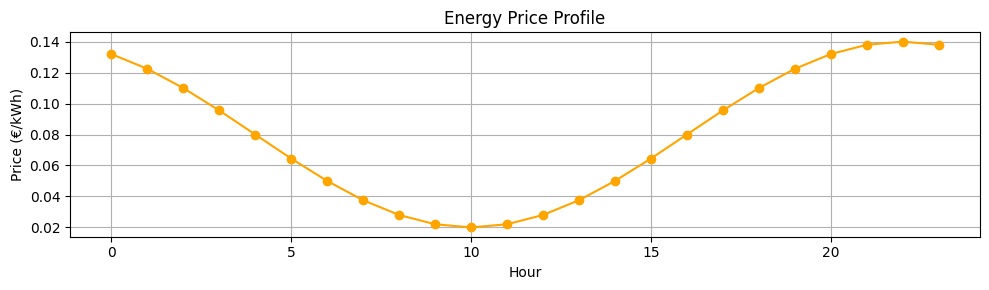

In [8]:
#price profile plot 
plt.figure(figsize=(10,3))
plt.plot(timesteps, price, color='orange', marker='o')
plt.xlabel("Hour")
plt.ylabel("Price (€/kWh)")
plt.title("Energy Price Profile")
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
prob = cp.Problem(objective, constraints)
result = prob.solve(solver=cp.OSQP)
print("Solve status:", prob.status)


Solve status: optimal


In [10]:
# Collect results
df = pd.DataFrame({"hour": timesteps, "load_kW": base_load, "pv_kW": pv, "price_eur_per_kWh": price})
df["grid_import_kW"] = G.value
for i, b in enumerate(batteries):
    df[f"ch_{b['id']}_kW"] = ch[i].value
    df[f"dis_{b['id']}_kW"] = dis[i].value
    df[f"soc_{b['id']}_kWh"] = soc[i].value[1:]
    df[f"throughput_{b['id']}_kWh"] = throughput[i].value

total_deg = sum(b["degradation_cost_per_kWh"] * np.sum(df[f"throughput_{b['id']}_kWh"]) for i,b in enumerate(batteries))
total_energy_cost = np.sum(df["grid_import_kW"] * df["price_eur_per_kWh"])
print("Solve status:", prob.status)
print(f"Total energy cost (€/day): {total_energy_cost:.2f}")
print(f"Total degradation cost (€/day): {total_deg:.2f}")
print(f"Total cost (€/day): {total_energy_cost + total_deg:.2f}")


df.to_csv("da_schedule_with_reserve.csv", index=False)
print("Saved schedule to da_schedule_with_reserve.csv")

Solve status: optimal
Total energy cost (€/day): 91.42
Total degradation cost (€/day): 3.53
Total cost (€/day): 94.95
Saved schedule to da_schedule_with_reserve.csv


In [11]:
# df

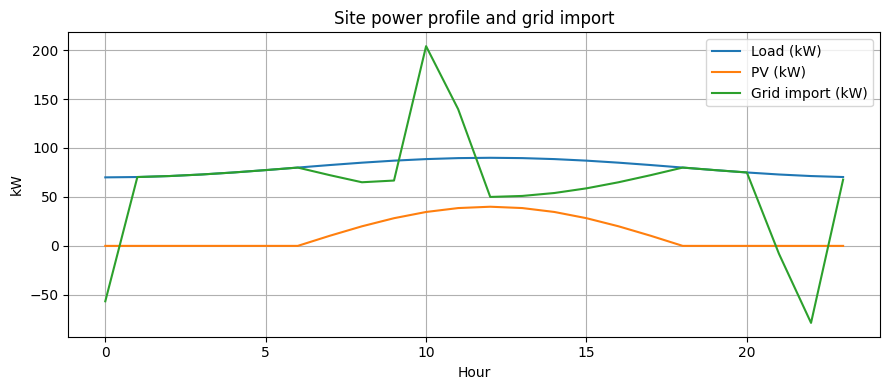

In [12]:
# Plot 1: net grid import vs load and PV
plt.figure(figsize=(9,4))
plt.plot(df["hour"], df["load_kW"], label="Load (kW)")
plt.plot(df["hour"], df["pv_kW"], label="PV (kW)")
plt.plot(df["hour"], df["grid_import_kW"], label="Grid import (kW)")
plt.xlabel("Hour")
plt.ylabel("kW")
plt.title("Site power profile and grid import")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

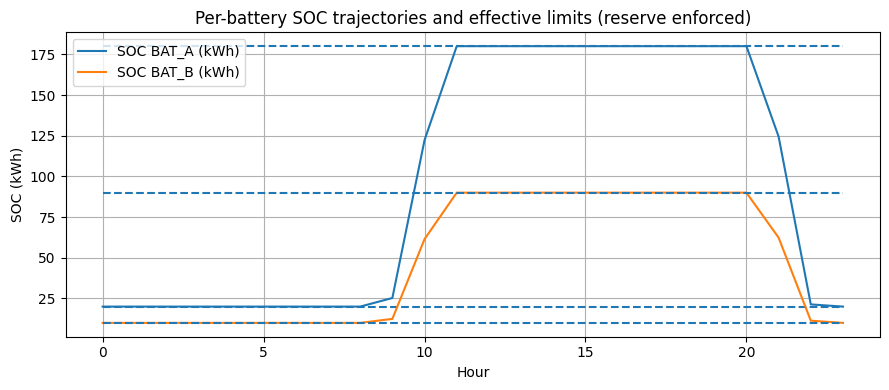

In [13]:
# Plot 2: SOC trajectories per battery (single plot per guidance)
plt.figure(figsize=(9,4))
for i,b in enumerate(batteries):
    plt.plot(df["hour"], df[f"soc_{b['id']}_kWh"], label=f"SOC {b['id']} (kWh)")
    # plot effective SOC limits as dashed lines
    E = b["capacity_kWh"]
    reserve = b["reserve_kWh"]
    soc_min_eff = b["soc_min"] * E + reserve/2.0
    soc_max_eff = b["soc_max"] * E - reserve/2.0
    plt.hlines([soc_min_eff, soc_max_eff], 0, T-1, linestyles='dashed')
plt.xlabel("Hour")
plt.ylabel("SOC (kWh)")
plt.title("Per-battery SOC trajectories and effective limits (reserve enforced)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

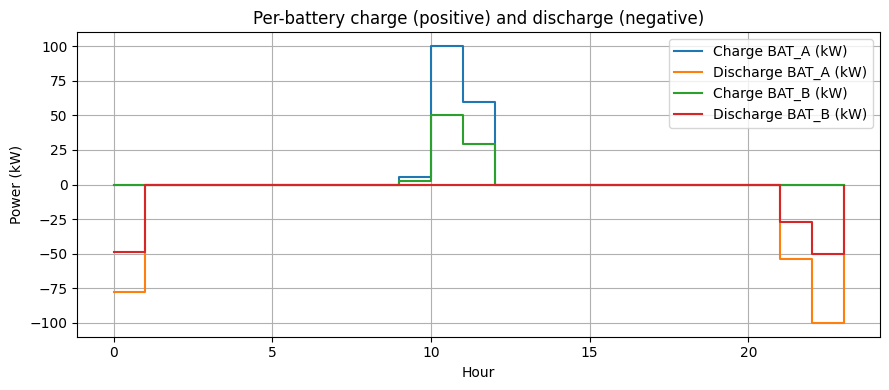

In [14]:
# Plot 3: per-battery charge/discharge schedule
plt.figure(figsize=(9,4))
for i,b in enumerate(batteries):
    plt.step(df["hour"], df[f"ch_{b['id']}_kW"], where='post', label=f"Charge {b['id']} (kW)")
    plt.step(df["hour"], -df[f"dis_{b['id']}_kW"], where='post', label=f"Discharge {b['id']} (kW)")
plt.xlabel("Hour")
plt.ylabel("Power (kW)")
plt.title("Per-battery charge (positive) and discharge (negative)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()